# New York City Motor Vehicle Collisions
GitHub Repository: https://github.com/skhiearth/NYC-Motor-Vehicle-Collisions

**Analysing and visualising Motor Vehicle Collisions in New York City with an objective to make the city roads safer using Data Science techniques. The [dataset](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95) used is provided by NYC Open Data and contains details on the crash event. The Motor Vehicle Collisions data tables contain information from all police reported motor vehicle collisions in NYC.**

In [1]:
# Import the required packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sodapy import Socrata

### Importing data

Download the static file from [here](https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD). Dynamic data can be fetched using the Socrata Open Data API (SODA). 
Note that SODA limits a single API call to 1000 rows, so please use the offset parameter to make multiple API calls
to fetch all rows.
The exact static file version used here has been uploaded to Google Drive, and made public. You may access this version from [here](https://drive.google.com/open?id=1Wv9yya3u3HjnP2XZbxouFUnyLD4plU4Y).

In [2]:
# Importing static dataset from .csv file
raw_data = pd.read_csv('datasets/Motor_Vehicle_Collisions_-_Crashes.csv')

print(raw_data.shape)
raw_data.head(3)

(904482, 29)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,04/02/2016,22:23,BRONX,10456.0,NaN,NaN,NaN,WESTCHESTER AVENUE,UNION AVENUE,NaN,...,NaN,NaN,NaN,NaN,3411047.0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
1,01/06/2020,12:50,NaN,NaN,NaN,NaN,NaN,PRINCE STREET,NaN,NaN,...,Failure to Yield Right-of-Way,NaN,NaN,NaN,4269674.0,Sedan,Tractor Truck Diesel,NaN,NaN,NaN
2,01/06/2020,13:16,MANHATTAN,10018.0,NaN,NaN,NaN,40 STREET,12 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4269909.0,Sedan,Bus,NaN,NaN,NaN


### Data Pre-processing and Cleaning

In [3]:
# Removing columns that have more than a third values as NaN
mask = raw_data.isna().sum() / len(raw_data) < 0.34
raw_data = raw_data.loc[:, mask]

# Removing columns that don't have a large contributing factor to EDA and Predictions
cols_to_drop = ['ZIP CODE', 'LOCATION', 
                'CONTRIBUTING FACTOR VEHICLE 2', 'VEHICLE TYPE CODE 2']
raw_data.drop(cols_to_drop, axis = 1, inplace = True)
print(raw_data.shape)

(904482, 17)


In [4]:
# Concatenating date and time columns
raw_data['CRASH_DATE_TIME'] = raw_data['CRASH DATE'] + ' ' + raw_data['CRASH TIME']

# Drop redundant date and time columns
cols_to_drop = ['CRASH DATE', 'CRASH TIME']
raw_data.drop(cols_to_drop, axis = 1, inplace = True)

In [5]:
# Convert Crash Date and time to datetime format
raw_data['CRASH_DATE_TIME']= pd.to_datetime(raw_data['CRASH_DATE_TIME'], 
                                            dayfirst=True, errors='coerce')

# Dropping rows with problematics dates
idx = raw_data[raw_data['CRASH_DATE_TIME'].isnull()].index
raw_data.drop(idx, axis = 0, inplace = True)

In [6]:
print(raw_data.shape)
raw_data.head(3)

(904477, 16)


,BOROUGH,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID,VEHICLE TYPE CODE 1,CRASH_DATE_TIME
0,BRONX,NaN,NaN,WESTCHESTER AVENUE,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Driver Inattention/Distraction,3411047.0,PASSENGER VEHICLE,2016-02-04 22:23:00
1,NaN,NaN,NaN,PRINCE STREET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lane Marking Improper/Inadequate,4269674.0,Sedan,2020-06-01 12:50:00
2,MANHATTAN,NaN,NaN,40 STREET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Following Too Closely,4269909.0,Sedan,2020-06-01 13:16:00


### Borough-wise Analysis

In [7]:
borough_wise = raw_data.groupby(['BOROUGH']).size().reset_index(name='NoOfAccidents')
borough_wise.head()

,BOROUGH,NoOfAccidents
0,BRONX,89247
1,BROOKLYN,189648
2,MANHATTAN,133376
3,QUEENS,164321
4,STATEN ISLAND,22822


The [GIS data](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm) with the Boundaries of Boroughs for New York City is obtained from NYC Open Data. The data is provided by the Department of City Planning (DCP).

In [8]:
import geopandas as gpd

# Import the ShapeFile for Borough Boundaries
fp = 'datasets/Borough Boundaries/geo_export_87071461-9196-46f3-8d1b-52fed88fb835.shp'
borough_geo = gpd.read_file(fp)
borough_geo['boro_name'] = borough_geo['boro_name'].str.upper() 
borough_geo.head()

merged_for_map = borough_geo.set_index('boro_name').join(borough_wise.set_index('BOROUGH'))

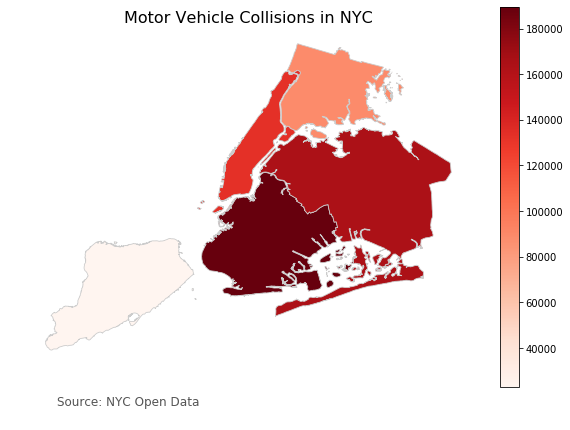

In [9]:
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 7))

# Drawing the Map
merged_for_map.plot(column = 'NoOfAccidents', cmap = 'Reds', linewidth = 0.8, 
                      ax = ax, edgecolor = '0.8')

# Map customizations
ax.axis('off')
ax.set_title('Motor Vehicle Collisions in NYC', size = 16)
ax.annotate('Source: NYC Open Data', xy = (0.1, .08),  
            xycoords = 'figure fraction', horizontalalignment = 'left', verticalalignment = 'top', 
            fontsize = 12, color = '#555555')

# Adding a color bar legend to the map
sm = plt.cm.ScalarMappable(cmap = 'Reds', 
                           norm = plt.Normalize(vmin = 22822, vmax = 189648))
cbar = fig.colorbar(sm)

# Export map
fig.savefig('plots/borough_wise_accidents.png', dpi=300)